# Softmax Regression Example

### 生成数据集
#### '<font color="blue">+</font>' 从高斯分布采样 (X, Y) ~ N(3, 6, 1, 1, 0).<br>
#### '<font color="green">o</font>' 从高斯分布采样  (X, Y) ~ N(6, 3, 1, 1, 0)<br>
#### '<font color="red">*</font>' 从高斯分布采样  (X, Y) ~ N(7, 7, 1, 1, 0)<br>

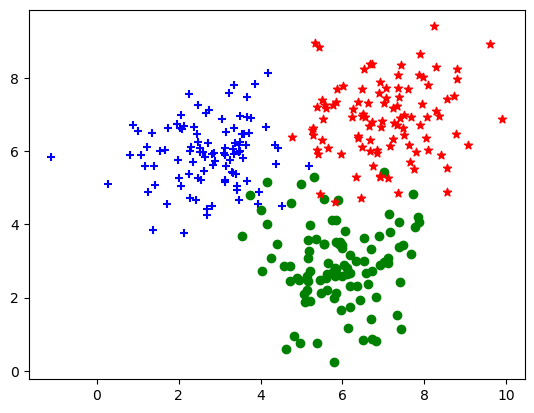

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

dot_num = 100
x_p = np.random.normal(3., 1, dot_num)
y_p = np.random.normal(6., 1, dot_num)
y = np.ones(dot_num)
C1 = np.array([x_p, y_p, y]).T

x_n = np.random.normal(6., 1, dot_num)
y_n = np.random.normal(3., 1, dot_num)
y = np.zeros(dot_num)
C2 = np.array([x_n, y_n, y]).T

x_b = np.random.normal(7., 1, dot_num)
y_b = np.random.normal(7., 1, dot_num)
y = np.ones(dot_num)*2
C3 = np.array([x_b, y_b, y]).T

plt.scatter(C1[:, 0], C1[:, 1], c='b', marker='+')
plt.scatter(C2[:, 0], C2[:, 1], c='g', marker='o')
plt.scatter(C3[:, 0], C3[:, 1], c='r', marker='*')

data_set = np.concatenate((C1, C2, C3), axis=0)
np.random.shuffle(data_set)


## 建立模型
建立模型类，定义loss函数，定义一步梯度下降过程函数

填空一：在`__init__`构造函数中建立模型所需的参数

填空二：实现softmax的交叉熵损失函数(不使用tf内置的loss 函数)

In [ ]:
class SoftmaxRegression():
    def __init__(self):
        '''============================='''
        # 填空一：构建模型所需的参数
        self.W = tf.Variable(
            shape=[2, 3], dtype=tf.float32,
            initial_value=tf.random.uniform(shape=[2, 3], minval=-0.1, maxval=0.1)
        )
        self.b = tf.Variable(
            shape=[3], dtype=tf.float32,
            initial_value=tf.zeros(shape=[3])
        )
        '''============================='''

        self.trainable_variables = [self.W, self.b]

    @tf.function
    def __call__(self, inp):
        logits = tf.matmul(inp, self.W) + self.b # shape(N, 3)
        pred = tf.nn.softmax(logits)
        return pred

@tf.function
def compute_loss(pred, label):
    label = tf.one_hot(tf.cast(label, dtype=tf.int32), dtype=tf.float32, depth=3)
    '''============================='''
    # 输入label shape(N, 3), pred shape(N, 3)
    # 输出 losses shape(N,) 每一个样本一个loss
    epsilon = 1e-12
    pred = tf.clip_by_value(pred, epsilon, 1. - epsilon)
    losses = -tf.reduce_sum(label * tf.math.log(pred), axis=1)
    '''============================='''
    loss = tf.reduce_mean(losses)

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(label,axis=1), tf.argmax(pred, axis=1)), dtype=tf.float32))
    return loss, accuracy

@tf.function
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        pred = model(x)
        loss, accuracy = compute_loss(pred, y)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, accuracy

### 实例化一个模型，进行训练

In [ ]:
model = SoftmaxRegression()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
x1, x2, y = list(zip(*data_set))
x = list(zip(x1, x2))
for i in range(1000):
    loss, accuracy = train_one_step(model, opt, x, y)
    if i%50==49:
        print(f'loss: {loss.numpy():.4}\t accuracy: {accuracy.numpy():.4}')

TypeError: in user code:

    File "<ipython-input-2-289ca13cee3c>", line 41, in train_one_step  *
        pred = model(x)
    File "<ipython-input-2-289ca13cee3c>", line 19, in __call__  *
        logits = tf.matmul(inp, self.W) + self.b # shape(N, 3)

    TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.


报错：    TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.解决办法：


1.   在 __call__ 方法中，添加 tf.cast(inp, tf.float32) 将输入转换为 float32 类型
2.   在 train_one_step 函数中，对输入的 x 和 y 都进行类型转换为 float32



In [ ]:
class SoftmaxRegression():
    def __init__(self):
        '''============================='''
        # 填空一：构建模型所需的参数
        self.W = tf.Variable(
            shape=[2, 3], dtype=tf.float32,
            initial_value=tf.random.uniform(shape=[2, 3], minval=-0.1, maxval=0.1)
        )
        self.b = tf.Variable(
            shape=[3], dtype=tf.float32,
            initial_value=tf.zeros(shape=[3])
        )
        '''============================='''

        self.trainable_variables = [self.W, self.b]

    @tf.function
    def __call__(self, inp):
        # 确保输入是float32类型
        inp = tf.cast(inp, tf.float32)
        logits = tf.matmul(inp, self.W) + self.b # shape(N, 3)
        pred = tf.nn.softmax(logits)
        return pred

@tf.function
def compute_loss(pred, label):
    label = tf.one_hot(tf.cast(label, dtype=tf.int32), dtype=tf.float32, depth=3)
    '''============================='''
    # 输入label shape(N, 3), pred shape(N, 3)
    # 输出 losses shape(N,) 每一个样本一个loss
    epsilon = 1e-12
    pred = tf.clip_by_value(pred, epsilon, 1. - epsilon)
    losses = -tf.reduce_sum(label * tf.math.log(pred), axis=1)
    '''============================='''
    loss = tf.reduce_mean(losses)

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(label,axis=1), tf.argmax(pred, axis=1)), dtype=tf.float32))
    return loss, accuracy

@tf.function
def train_one_step(model, optimizer, x, y):
    # 确保输入是float32类型
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.float32)

    with tf.GradientTape() as tape:
        pred = model(x)
        loss, accuracy = compute_loss(pred, y)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, accuracy

# 实例化模型并训练
model = SoftmaxRegression()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
x1, x2, y = list(zip(*data_set))
x = list(zip(x1, x2))
for i in range(1000):
    loss, accuracy = train_one_step(model, opt, x, y)
    if i%50==49:
        print(f'loss: {loss.numpy():.4}\t accuracy: {accuracy.numpy():.4}')

loss: 0.7627	 accuracy: 0.8333
loss: 0.6254	 accuracy: 0.89
loss: 0.5504	 accuracy: 0.8967
loss: 0.502	 accuracy: 0.9
loss: 0.4676	 accuracy: 0.91
loss: 0.4416	 accuracy: 0.91
loss: 0.4212	 accuracy: 0.9067
loss: 0.4045	 accuracy: 0.91
loss: 0.3907	 accuracy: 0.91
loss: 0.379	 accuracy: 0.91
loss: 0.369	 accuracy: 0.91
loss: 0.3602	 accuracy: 0.91
loss: 0.3525	 accuracy: 0.9133
loss: 0.3456	 accuracy: 0.9133
loss: 0.3395	 accuracy: 0.9133
loss: 0.334	 accuracy: 0.9133
loss: 0.3289	 accuracy: 0.9133
loss: 0.3243	 accuracy: 0.9133
loss: 0.3201	 accuracy: 0.9133
loss: 0.3162	 accuracy: 0.9133


## 结果展示

(10000, 2)


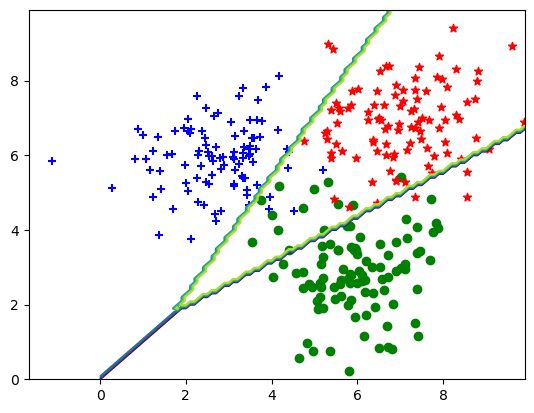

In [ ]:
plt.scatter(C1[:, 0], C1[:, 1], c='b', marker='+')
plt.scatter(C2[:, 0], C2[:, 1], c='g', marker='o')
plt.scatter(C3[:, 0], C3[:, 1], c='r', marker='*')

x = np.arange(0., 10., 0.1)
y = np.arange(0., 10., 0.1)

X, Y = np.meshgrid(x, y)
inp = np.array(list(zip(X.reshape(-1), Y.reshape(-1))), dtype=np.float32)
print(inp.shape)
Z = model(inp)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(X.shape)
plt.contour(X,Y,Z)
plt.show()